In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
import numpyro

numpyro.set_host_device_count(4)

import numpy as np
import statsmodels.api as sm
import pandas as pd

from statsmodels.tsa.base.datetools import dates_from_str

import pymc as pm
import pytensor.tensor as pt
import arviz as az

import matplotlib.pyplot as plt
import sys

sys.path.append("..")
import pymc_experimental.statespace as pmss

config = {
    "figure.figsize": [12.0, 4.0],
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

In [2]:
from pytensor.link.jax.dispatch import jax_funcify
from pytensor.tensor.basic import Tri
import jax.numpy as jnp
from pytensor.graph.basic import Constant
from pytensor.tensor.nlinalg import MatrixPinv


@jax_funcify.register(Tri)
def jax_funcify_Tri(op, node, **kwargs):
    # node.inputs is N, M, k
    const_args = [getattr(x, "data", None) for x in node.inputs]

    def tri(*args):
        # args is N, M, k
        args = [x if const_x is None else const_x for x, const_x in zip(args, const_args)]
        return jnp.tri(*args, dtype=op.dtype)

    return tri


@jax_funcify.register(MatrixPinv)
def jax_funcify_Pinv(op, **kwargs):
    def pinv(x):
        return jnp.linalg.pinv(x)

    return pinv

# Introduction

-- TODO: Write a short introduction about VAR models.

# Data

For data, we will use a sample dataset distributed with Statsmodels, and used in their [example on VAR modeling](https://www.statsmodels.org/stable/vector_ar.html). 

In [3]:
mdata = sm.datasets.macrodata.load_pandas().data
mdata.index = pd.DatetimeIndex(
    mdata[["year", "quarter"]].applymap(lambda x: str(int(x))).apply(lambda x: "Q".join(x), axis=1)
)
data = mdata[["realgdp", "realcons", "realinv"]].apply(np.log).diff().dropna()
data.index.freq = data.index.inferred_freq

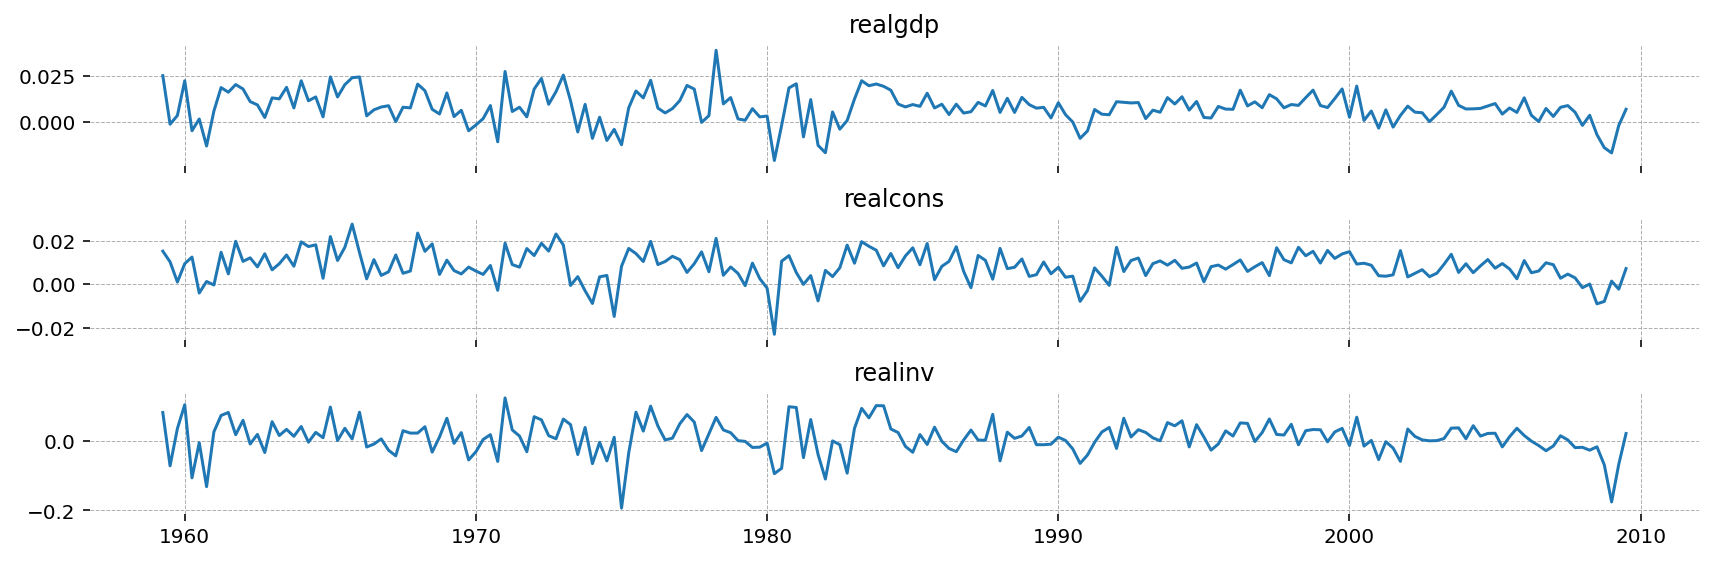

In [4]:
fig, ax = plt.subplots(3, 1, sharex=True)
for var, axis in zip(data, fig.axes):
    axis.plot(data[var])
    axis.set(title=var)
fig.tight_layout()
plt.show()

## Statsmodels Baseline

TODO: Add some commentary

In [5]:
sm_mod = sm.tsa.VARMAX(data, order=(2, 0), trend="n")
sm_res = sm_mod.fit(disp=0)
sm_res.summary()

Dep. Variable:,"['realgdp', 'realcons', 'realinv']",No. Observations:,202
Model:,VAR(2),Log Likelihood,1950.186
Date:,"Sat, 20 May 2023",AIC,-3852.371
Time:,12:51:23,BIC,-3772.973
Sample:,04-01-1959,HQIC,-3820.247
,- 07-01-2009,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.38, 2.65, 0.98",Jarque-Bera (JB):,"15.14, 3.83, 22.58"
Prob(Q):,"0.54, 0.10, 0.32",Prob(JB):,"0.00, 0.15, 0.00"
Heteroskedasticity (H):,"0.27, 0.45, 0.76",Skew:,"0.44, 0.21, -0.50"
Prob(H) (two-sided):,"0.00, 0.00, 0.26",Kurtosis:,"4.02, 3.53, 4.30"


# PyMC Statespace

To fit a VAR model with `pymc-statespace`, use the `BayesianVARMAX` model. We will recieve a message giving the names of the parameters we need to set priors for. In this case, we need:

- `x0`, a guess at the initial state of the system. 
- `P0`, a guess at the initial covaraince of the system
- `ar_params`, the autoregressive parameters
- `state_cov`, the covariance matrix of the shocks to the system

Note that statsmodels only estimated `ar_params` and `state_cov`. They handle *initialization* of the Kalman Filter, that is, selection of `x0` and `P0`, using other methods. Since we're in a Bayesian framework, though, nothing stops us from estimating these parameters. `x0` is clearly going to be centered on zero. `P0` is a bit more abstract. We could remove it by doing some linear algebra - you can ask for this by setting `stationary_initialzation = True`. This option is currently not supported in JAX, though, so we have to do it a harder way.

In [6]:
bvar_mod = pmss.BayesianVARMAX(
    data.values,
    order=(2, 0),
    stationary_initialization=False,
    measurement_error=False,
    filter_type="standard",
)

Model successfully initialized! The following parameters should be assigned priors inside a PyMC model block: x0, P0, ar_params, state_cov


In [7]:
coords = {
    "date": data.index,
    "equation": data.columns,
    "state": data.columns,
    "lag": np.arange(bvar_mod.p, dtype="int"),
}

with pm.Model(coords=coords) as var_mod:
    x0 = pm.Normal("x0", size=6)
    P0 = pm.Deterministic("P0", pt.diag(np.array(data.var().values.tolist() * 2)))

    state_chol, _, _ = pm.LKJCholeskyCov(
        "state_chol", eta=1, n=bvar_mod.k_posdef, sd_dist=pm.Exponential.dist(lam=1)
    )

    ar_params = pm.Normal("ar_params", mu=0, sigma=2, dims=["equation", "lag", "state"])
    state_cov = pm.Deterministic("state_cov", state_chol @ state_chol.T, dims=["equation", "state"])

    # I **DO NOT** recommended trying to run this model in anything but JAX mode, sorry Windows gang.
    bvar_mod.build_statespace_graph(mode="JAX")

    # You can also ask for the smoother, but we're not using it in this notebook
    #     bvar_mod.build_smoother_graph(mode="JAX")

    # Save this in the trace for forcasting and impulse response
    pm.Deterministic("T", bvar_mod.ssm["transition"])

You can see that the filtered, predicted, and smoothed states and covariances, as well as a log-likelihood term, have been automatically added to our model.

In [8]:
var_mod

                   x0 ~ Normal(0, 1)
           state_chol ~ _lkjcholeskycov(3, 1, Exponential(f()))
            ar_params ~ Normal(0, 2)
                   P0 ~ Deterministic(f())
      state_chol_corr ~ Deterministic(f(state_chol))
      state_chol_stds ~ Deterministic(f(state_chol))
            state_cov ~ Deterministic(f(state_chol))
      filtered_states ~ Deterministic(f(ar_params, x0, state_chol))
     predicted_states ~ Deterministic(f(ar_params, x0, state_chol))
predicted_covariances ~ Deterministic(f(ar_params, x0, state_chol))
 filtered_covariances ~ Deterministic(f(ar_params, x0, state_chol))
                    T ~ Deterministic(f(ar_params, x0, state_chol))
       log_likelihood ~ Potential(f(ar_params, x0, state_chol))

### Digression: A note on representation

Internally, the VAR is represented in so-called "companion form". For a VAR(2, 0) with 3 states, $x_t$, $y_t$, and $z_t$ this will have the form:

$$\begin{bmatrix} x_t \\ y_y \\z_t \\ x_{t-1} \\ y_{t-1} \\ z_{t-1} \end{bmatrix} = 
\begin{bmatrix} 
a_{x,x,1} & a_{x,y,1} & a_{x,z,1} & a_{x,x,2} & a_{x,y,2} & a_{x,z,2} \\ 
a_{y,x,1} & a_{y,y,1} & a_{y,z,1} & a_{y,x,2} & a_{y,y,2} & a_{y,z,2} \\
a_{z,x,1} & a_{z,y,1} & a_{z,z,1} & a_{z,x,2} & a_{z,y,2} & a_{z,z,2} \\ 
1 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} x_{t-1} \\ y_{t-1} \\ z_{t-1} \\ x_{t-2} \\ y_{t-2} \\ z_{t-1} \end{bmatrix}$$

The long and short of it is that we need to give `k_states ** 2 * ar_order` coefficients to the model. That's easy to do using PyMC's `dims`, as we did above. But we also need to make sure that things get to the right place in the matrix, so that we have the right interpertation of the coefficients when we inspect the trace later.

Internally, when you call `bvar_mod.build_statespace_graph`, `pymc_experimental.statespace` is going to:

1. Scan through the PyMC model looking for the variables it asked for when you called the constructor.
2. Ravel all these variables and concatenate them together into a single vector called "theta".
3. One variable at a time, read "theta" like tape. For each chunk of variables, reshape them into the expected shape and put them in the correct location in the correct matrix.

We are worried about where the `ar_coefs` end up, so let's look at an example. We start with a 3d tensor, because PyMC makes it really easy to decalare the variables that way. It will look like a matrix of three 3-by-2 matrices:

$\begin{bmatrix}
\begin{bmatrix} a_{x,1,x} & a_{x,1,y} & a_{x,1,z} \\ a_{x,2,x} & a_{x,2,y} & a_{x,2,z} \end{bmatrix} \\
\begin{bmatrix} a_{y,1,x} & a_{y,1,y} & a_{y,1,z} \\ a_{y,2,x} & a_{y,2,y} & a_{y,2,z}\end{bmatrix} \\
\begin{bmatrix} a_{z,1,x} & a_{z,1,y} & a_{z,1,z} \\ a_{z,2,x} & a_{z,2,y} & a_{z,2,z} \end{bmatrix} \\
\end{bmatrix}$

Internally, `pymc_experimental.statespace` ravels this into a vector. Because ravel unwinds arrays starting from the first dimension and working left-to-right, we end up with this:
$\begin{bmatrix}
a_{x,1,x} & a_{x,1,y} & a_{x,1,z} & a_{x,2,x} & a_{x,2,y} & a_{x,2,z} & a_{y,1,x} & a_{y,1,y} & a_{y,1,z} & a_{y,2,x} & a_{y,2,y} & a_{y,2,z} & a_{z,1,x} & a_{z,1,y} & a_{z,1,z} & a_{z,2,x} & a_{z,2,y} & a_{z,2,z}\end{bmatrix}$

For those of you used to working with $\text{vec}$ operators, note that this is $\text{vec}(A^T)$, not $\text{vec}(A)$!

Then it reshapes it into the companion shape, which is `(k_endog, k_endog * ar_order)`, as shown above. This will become:

$\begin{bmatrix}a_{x,1,x} & a_{x,1,y} & a_{x,1,z} & a_{x,2,x} & a_{x,2,y} & a_{x,2,z} \\ a_{y,1,x} & a_{y,1,y} & a_{y,1,z} & a_{y,2,x} & a_{y,2,y} & a_{y,2,z} \\ a_{z,1,x} & a_{z,1,y} & a_{z,1,z} & a_{z,2,x} & a_{z,2,y} & a_{z,2,z}\end{bmatrix}$

Notice that everything has landed where we want it. The rows of this matrix correspond to the equations (the first index), and the columns correspond to the lagged variables. Finally, the indexes are sorted first by state, then by lag. This is exactly what we want. But this would **not** have had the correct interpretation if we had chosen a different ordering of the dimensions! If we had instead chosen `dims = ['lag', 'equation', 'state']` when making `ar_params`, no error would have been raised but the labels on all our coefficients would have been wrong! 

The moral of this story is to be careful about how you declare the dimensions of your prior!

## Fit the model

With everything declared, we can call `pm.sample` as usual.

In [9]:
with var_mod:
    idata = pm.sample(nuts_sampler="numpyro", target_accept=0.95)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: Could not broadcast dimensions) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: Could not broadcast dimensions) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/jesse/mambaforge/envs/pymc-state

Compiling...
Compilation time =  0:00:05.473232
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:22:29.816586
Transforming variables...
Transformation time =  0:00:04.949457


In [10]:
idata.sample_stats.diverging.sum().values

array(9)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: >

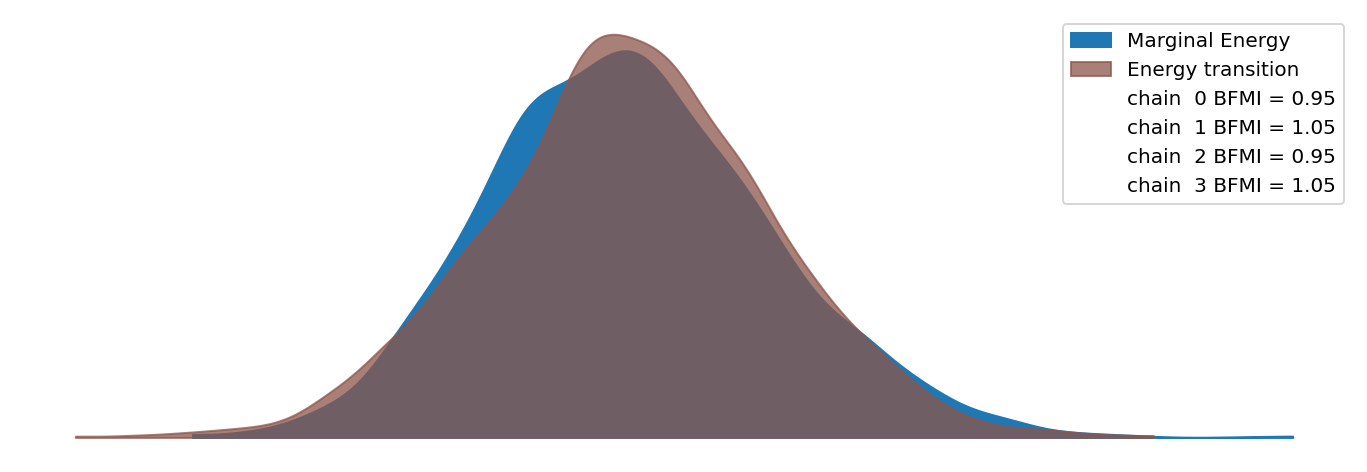

In [11]:
az.plot_energy(idata)

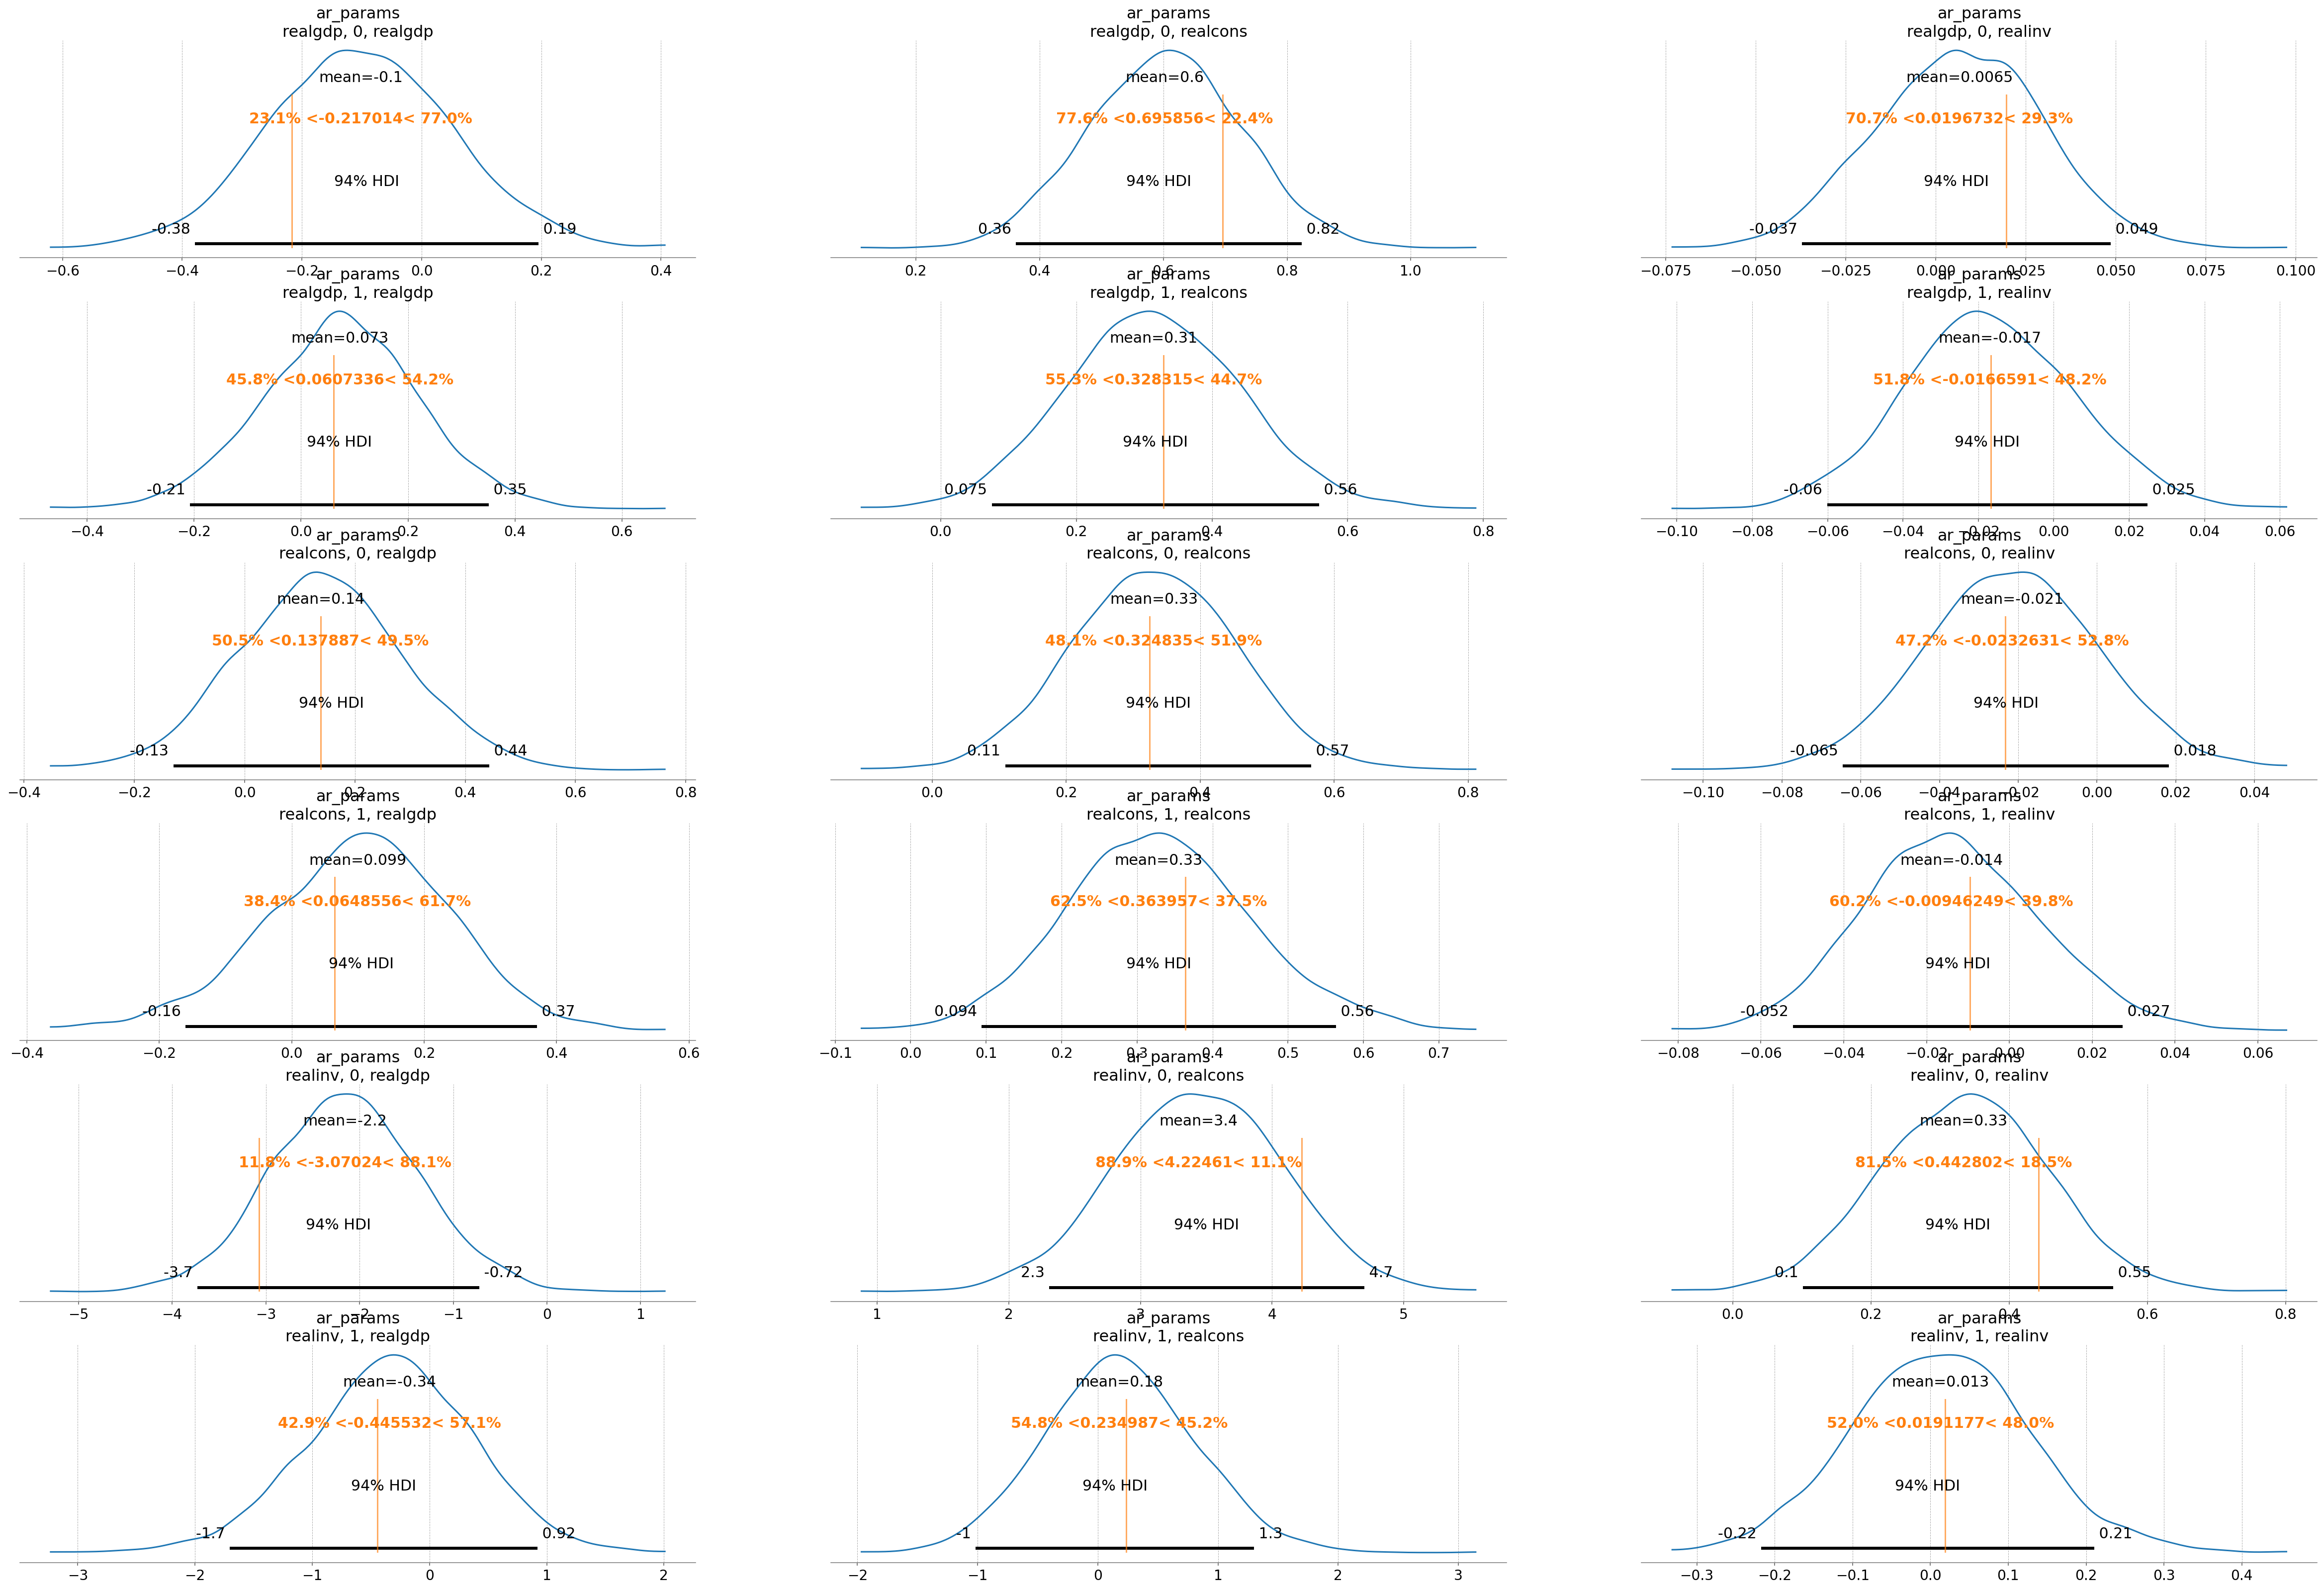

In [12]:
az.plot_posterior(idata, var_names=["ar_params"], ref_val=sm_res.params.iloc[:18].values.tolist());

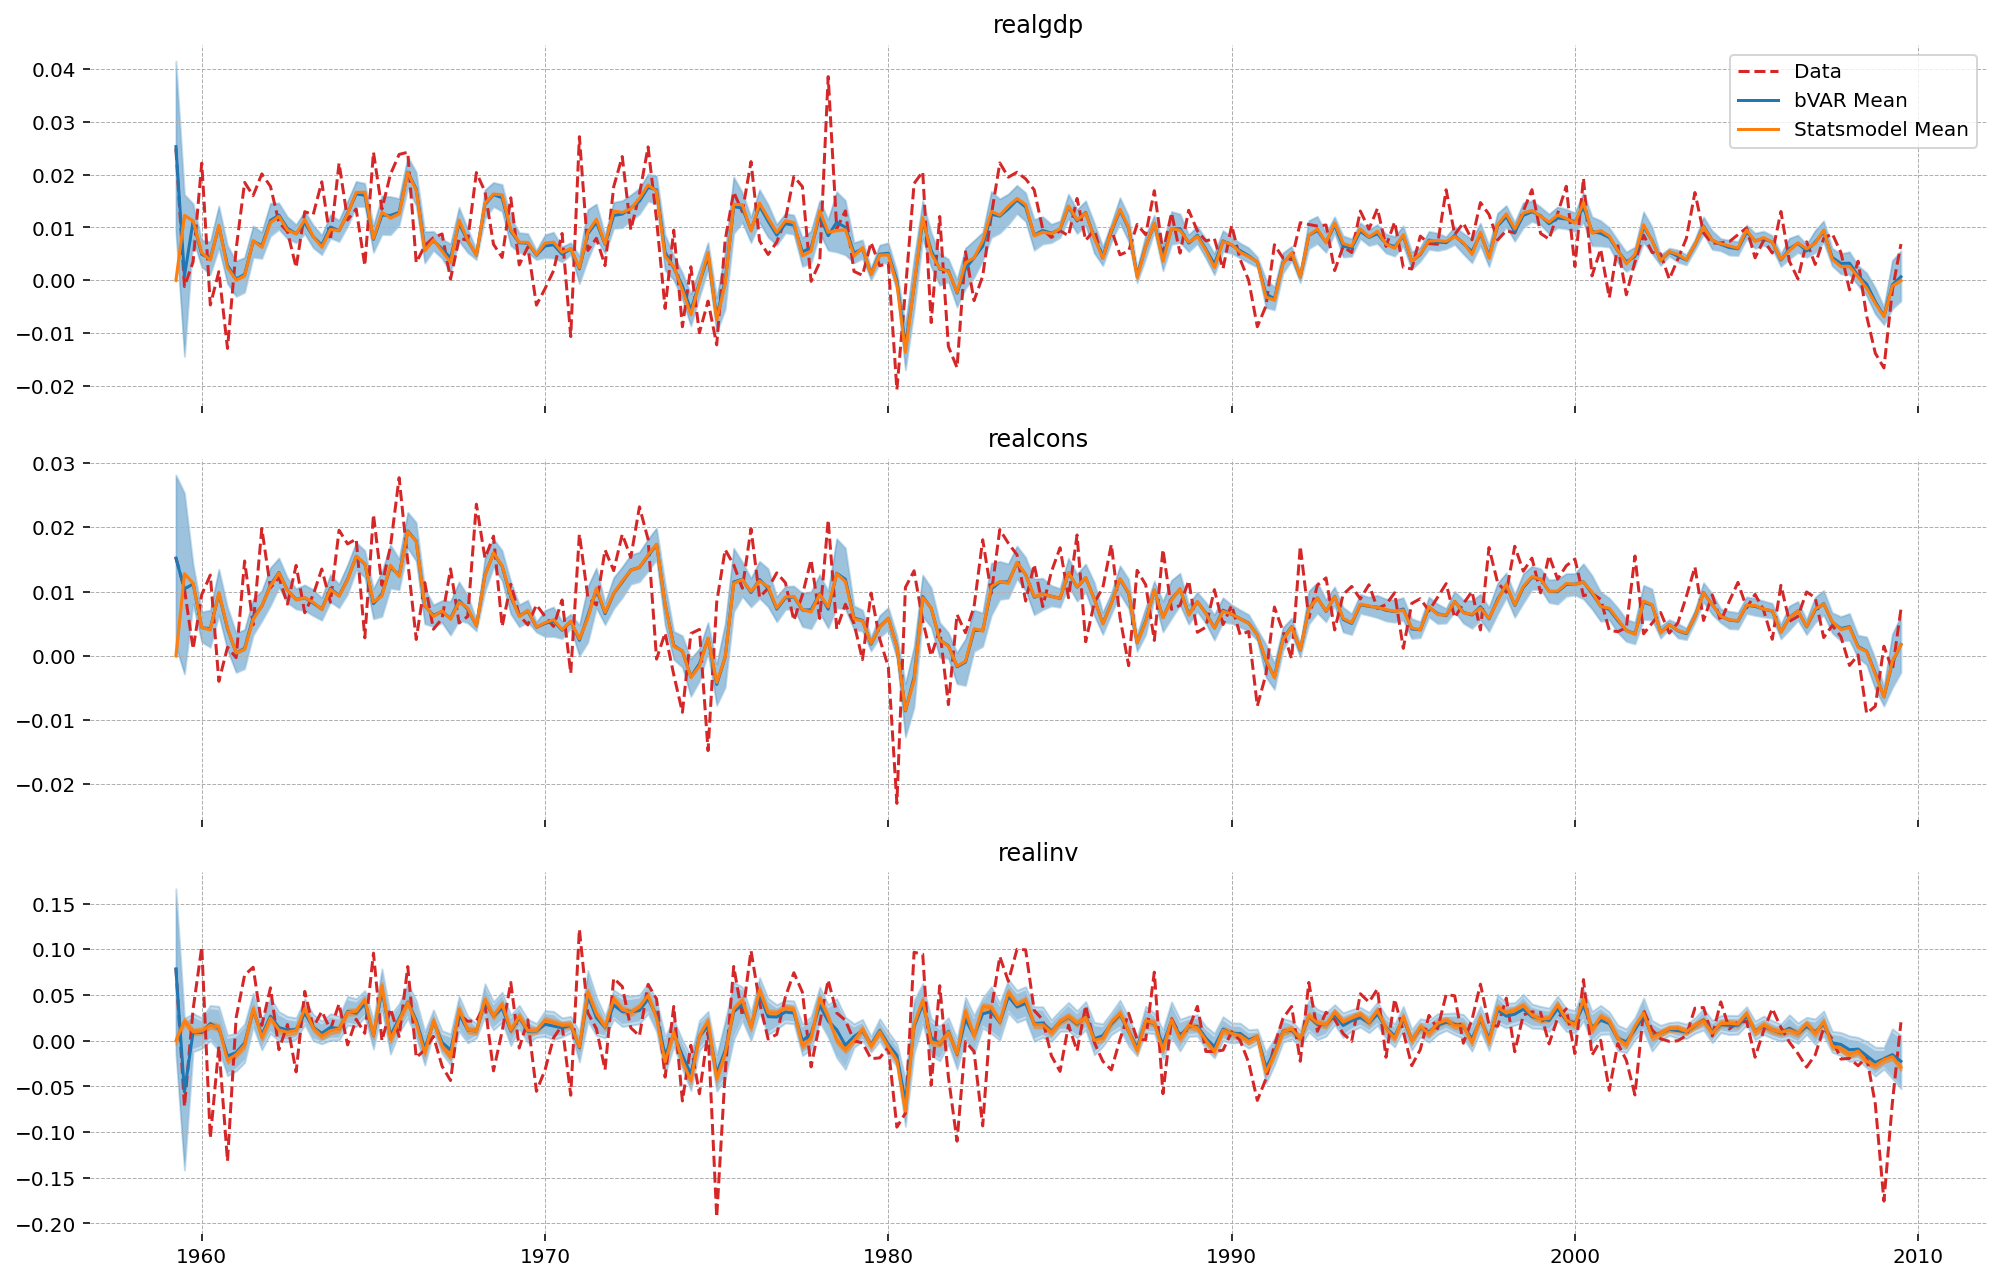

In [13]:
output_type = "predicted"

post = az.extract(idata, "posterior")
out_mean = getattr(post, f"{output_type}_states")
hdi_mean = getattr(
    az.hdi(getattr(idata.posterior, f"{output_type}_states")), f"{output_type}_states"
)

out_cov = getattr(post, f"{output_type}_covariances")
hdi_cov = getattr(
    az.hdi(getattr(idata.posterior, f"{output_type}_covariances")), f"{output_type}_covariances"
)

norm_95 = np.array([-1.98, 1.98]).reshape(-1, 1)

fig, ax = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
plot_slice = slice(None, -1) if output_type == "predicted" else slice(None, None)
for i, (var, axis) in enumerate(zip(data, fig.axes)):
    mu = out_mean.mean(dim="sample").values.squeeze()[plot_slice, i]
    mu_hdi = hdi_mean.values[plot_slice, i].squeeze().T

    cov = out_cov.mean(dim="sample").values.squeeze()[plot_slice, i, i]
    cov_hdi = hdi_cov.values[plot_slice, i, i].squeeze().T

    axis.plot(data[var], ls="--", color="tab:red", label="Data")
    axis.plot(data.index, mu, label="bVAR Mean")
    axis.fill_between(data.index, *mu_hdi, alpha=0.25)
    axis.fill_between(data.index, *(mu_hdi + norm_95 * cov_hdi), alpha=0.25, color="tab:blue")

    mu = sm_res.predict()[var]
    std = np.sqrt(sm_res.predicted_state_cov.reshape(6, 6, -1)[i, i, :-1].T)

    axis.plot(data.index, mu, color="tab:orange", label="Statsmodel Mean")
    axis.fill_between(data.index, mu - 1.96 * cov, mu + 1.96 * cov, color="tab:orange", alpha=0.5)

    axis.set(title=var)

ax[0].legend()
fig.tight_layout()
plt.show()

# IRF 

IRFs are nice because we have the transition matrix, so we just set some shocks and simulate the model.

In [14]:
sim_len = 30
T_post = az.extract(idata, "posterior")["T"].values.transpose(2, 0, 1)
R = bvar_mod.ssm["selection"].eval()

n_sims = T_post.shape[0]
sim_data = np.empty((n_sims, sim_len, 6))
sim_data[:, 0, :] = 0

shock_seq = np.zeros((sim_len, 3))
shock_var = "realgdp"
shock_size = 1
shock_time = 0

shock_var_idx = data.columns.tolist().index(shock_var)
shock_seq[shock_time, shock_var_idx] = shock_size

for t in range(1, sim_len):
    sim_data[:, t, :] = (
        np.einsum("bnm, bm -> bn", T_post, sim_data[:, t - 1, :]) + (R @ shock_seq[t - 1])[None]
    )

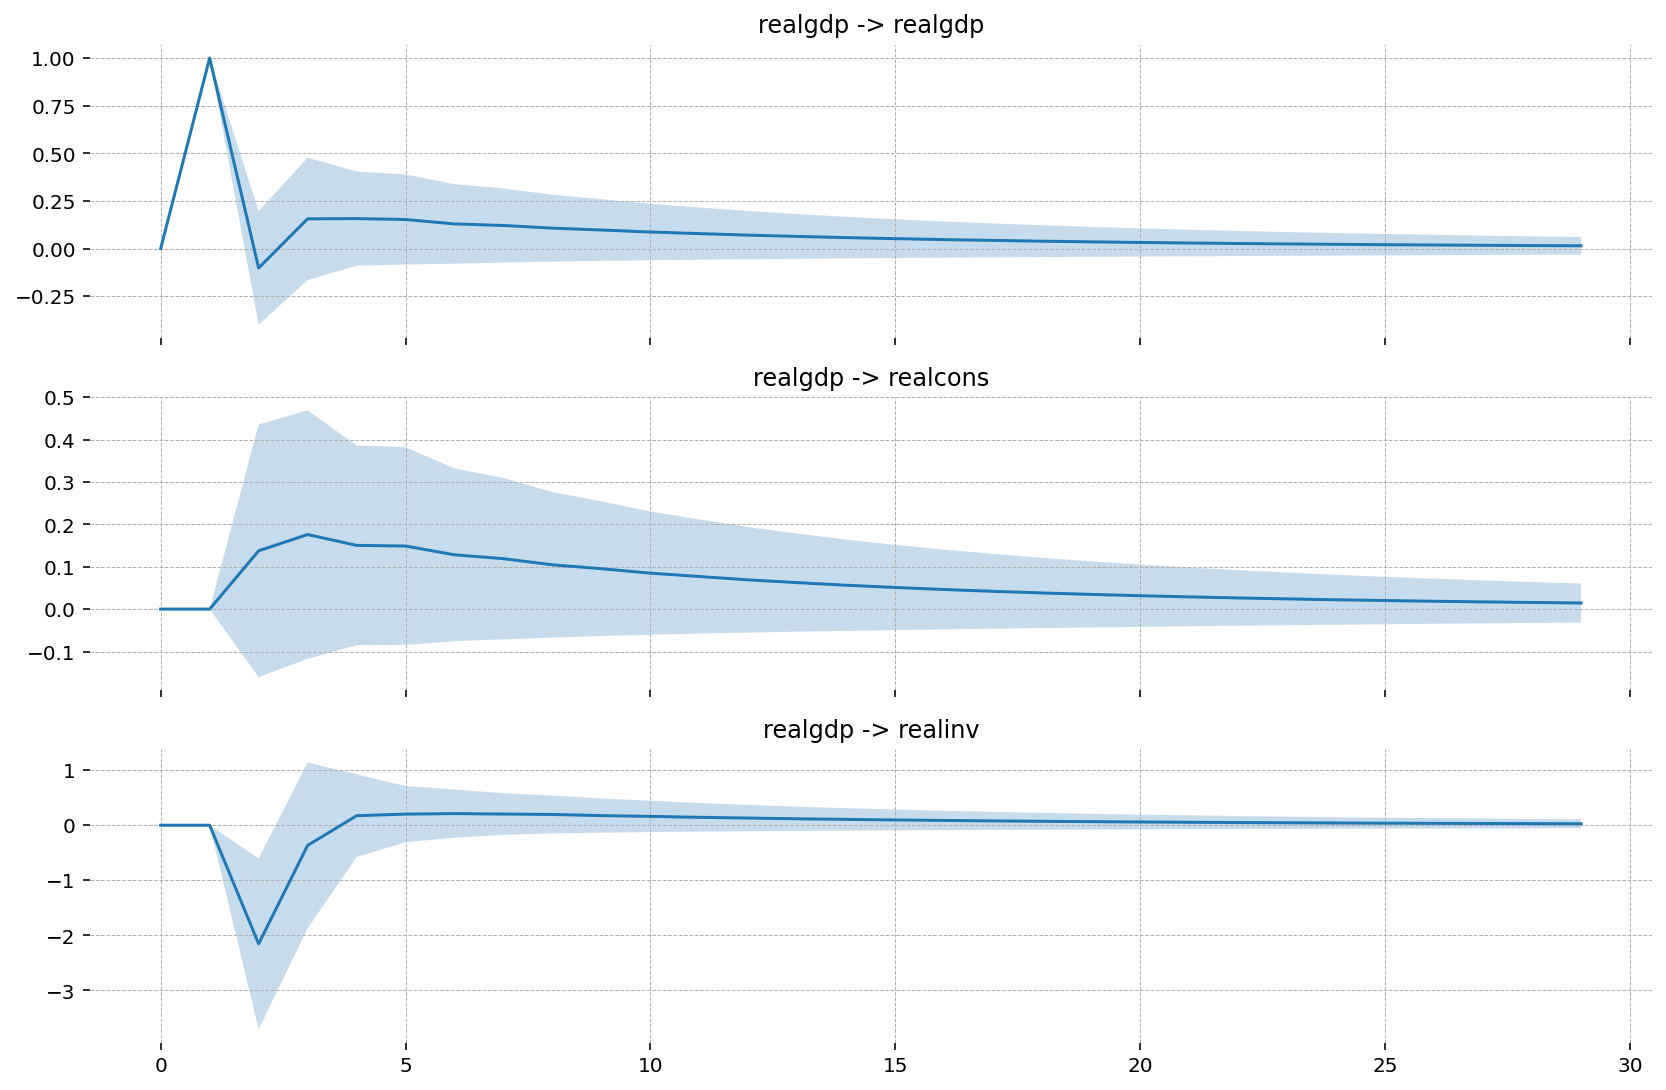

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

for i, (var, axis) in enumerate(zip(data, fig.axes)):
    mu = sim_data.mean(axis=0)[:, i]
    std = sim_data.std(axis=0)[:, i]

    axis.plot(np.arange(sim_len), mu)
    axis.fill_between(np.arange(sim_len), mu - 1.96 * std, mu + 1.96 * std, alpha=0.25)
    axis.set_title(f"{shock_var} -> {var}")

## Forcasting

Pretty much the same thing as IRFs, we just have to set the initial state to the last observations and set all the shocks to zero.

In [16]:
forcast_len = 30
n_lags = bvar_mod.p

T_post = az.extract(idata, "posterior")["T"].values.transpose(2, 0, 1)
R = bvar_mod.ssm["selection"].eval()

n_sims = T_post.shape[0]
forcast_data = np.empty((n_sims, sim_len, 6))
forcast_data[:, 0, :] = 0

forcast_data[:, 0, :] = data.values[-n_lags:, :].ravel()

for t in range(1, sim_len):
    forcast_data[:, t, :] = np.einsum("bnm, bm -> bn", T_post, forcast_data[:, t - 1, :])

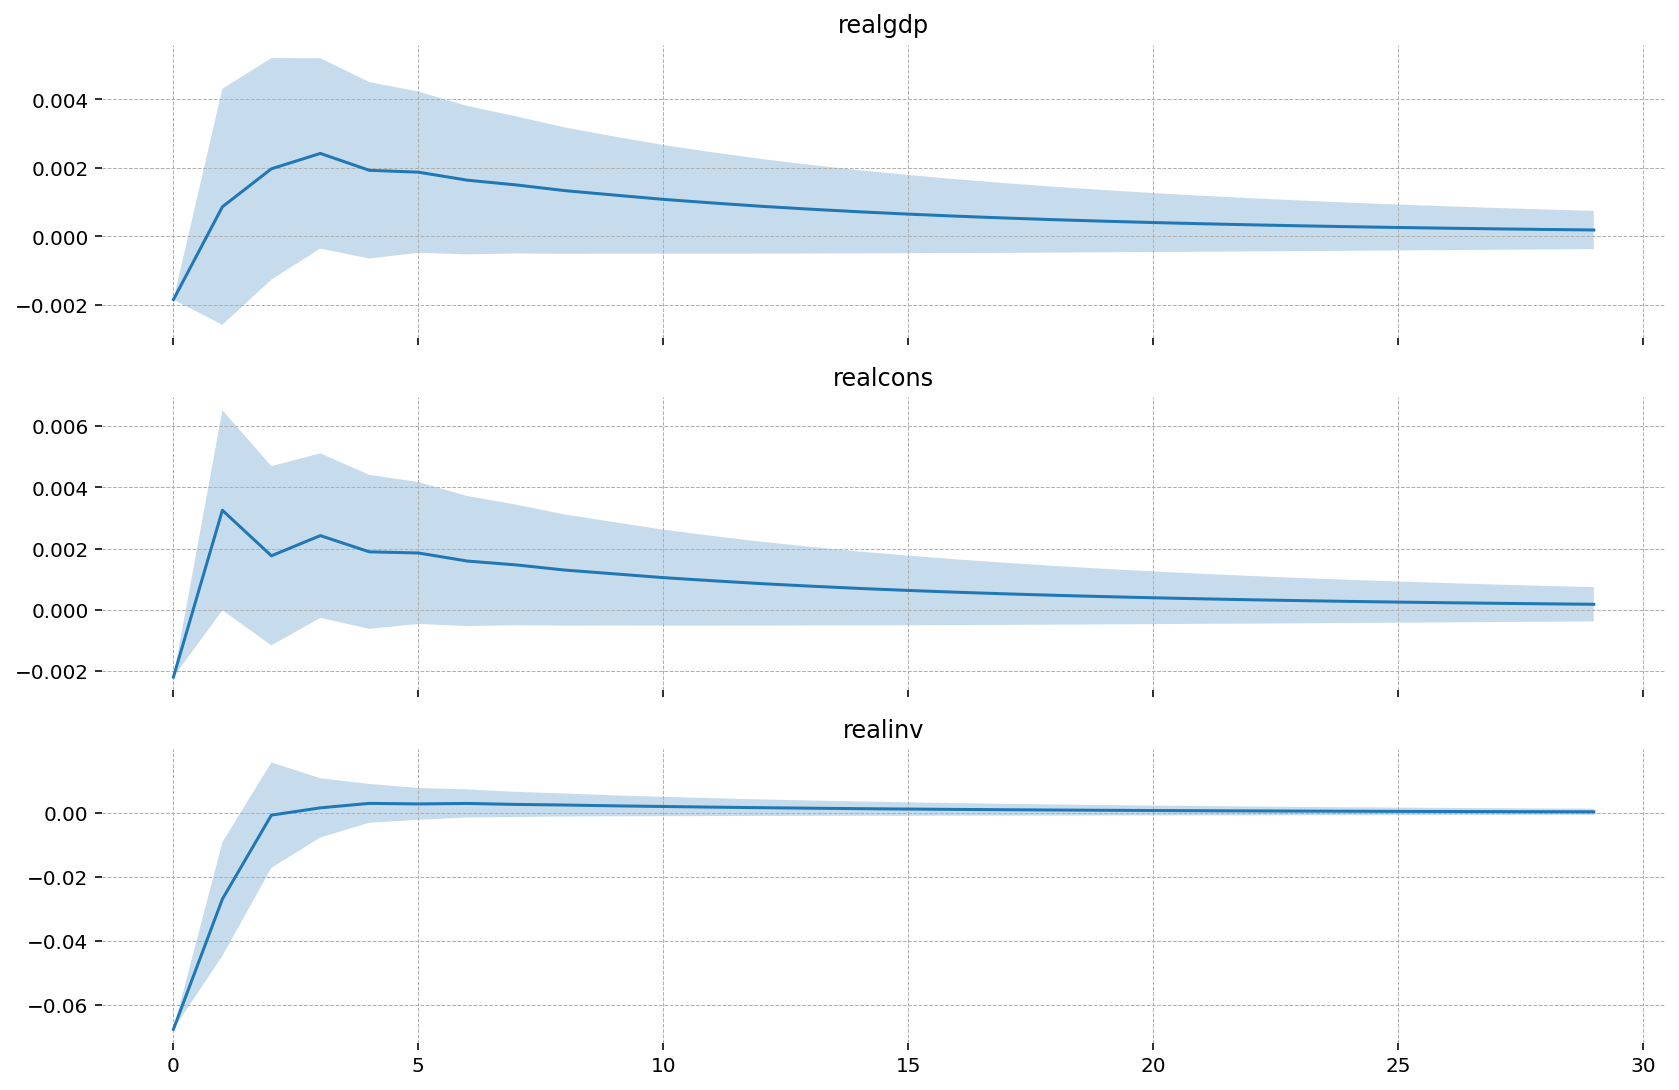

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

for i, (var, axis) in enumerate(zip(data, fig.axes)):
    mu = forcast_data.mean(axis=0)[:, i]
    std = forcast_data.std(axis=0)[:, i]

    axis.plot(np.arange(sim_len), mu)
    axis.fill_between(np.arange(sim_len), mu - 1.96 * std, mu + 1.96 * std, alpha=0.25)
    axis.set_title(var)